<a href="https://colab.research.google.com/github/pongsapaks/Detection-depression/blob/main/dl_transformer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP ENV

In [1]:
import os

import pandas as pd
import numpy as np


import torch
import torch.nn as nn
import torchaudio
import torch.optim as optim
from torchaudio.models import Wav2Vec2Model
from torchaudio.transforms import MelSpectrogram, MelScale, Spectrogram
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

torch.cuda.is_available()

False

In [4]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)
# Set the device globally
torch.set_default_device(device)

cpu


In [ ]:
import os
import re
import pandas as pd
from scipy.io import wavfile

def audio_to_dataframe(directory):
    rows_list = []

    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        filenames = [f for f in os.listdir(folder_path) if f.lower().endswith('.wav')]

        if ".DS_Store" in filenames:
            filenames.remove(".DS_Store")

        for filename in filenames:
            audio_path = os.path.join(folder_path, filename)
            m = re.search("(\d{3})_AUDIO.wav", filename)

            if m:
                person_id = m.group(1)
                p = {}
                p["personId"] = person_id

                # Using scipy's wavfile to read the audio file
                sample_rate, samples = wavfile.read(audio_path)
                p["audio_samples"] = samples
                p["sample_rate"] = sample_rate

                rows_list.append(p)

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'audio_samples', 'sample_rate'])
    all_participants.to_csv(os.path.join(directory, 'all_audio.csv'), sep=',', index=False)
    print("Audio file information was created")
    return all_participants

# Example usage
audio_directory = "/content/drive/My Drive/data/"
audio_df = audio_to_dataframe(audio_directory)

In [ ]:
audio_df

In [ ]:
import librosa
import pandas as pd

# Sample DataFrame creation (replace this with your actual DataFrame)
# audio_df = pd.DataFrame({
#     'audio_samples': [your_audio_samples],
#     'sample_rate': [your_sample_rates]
# })

# Initialize lists to store the new data
trimmed_waveforms = []
trimmed_durations = []

for index, row in audio_df.iterrows():
    audio_samples = row['audio_samples']
    sample_rate = row['sample_rate']

    # Apply trimming with librosa
    waveform_cut, _ = librosa.effects.trim(audio_samples, top_db=10)
    trimmed_list = waveform_cut.tolist()

    # Append the trimmed waveform and its duration to the lists
    trimmed_waveforms.append(trimmed_list)
    trimmed_durations.append(len(trimmed_list) / sample_rate if len(trimmed_list) > 0 else 0)

# Assign the lists as new columns in the DataFrame
audio_df['waveform_trimmed'] = trimmed_waveforms
audio_df['duration_trimmed'] = trimmed_durations

print(audio_df.head())  # Print the first few rows to verify the results

In [ ]:
plt.figure(figsize=(14, 5))

# Ensure audio samples are in floating-point format
audio_samples = np.array(audio_df['waveform_trimmed'].iloc[0], dtype=float)
sample_rate = audio_df['sample_rate'].iloc[0]

librosa.display.waveshow(audio_samples, sr=sample_rate)
plt.title(f"Audio Waveform - Person {audio_df['personId'].iloc[0]}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# INPUT

In [ ]:

# base_path = 'gdrive/MyDrive/nida/deep_learning_final/'
# data_dir = 'data'
train_annontation_file = 'Label/train_split_Depression_AVEC2017.csv'
valid_annontation_file = 'Label/dev_split_Depression_AVEC2017.csv'
test_annontation_file = 'Label/full_test_split.csv'


SAMPLE_RATE = 16000

# READ DATA

In [ ]:

TRAIN_ANNOTATIONS_FILE = os.path.join(base_path, data_dir, train_annontation_file)
VALID_ANNOTATIONS_FILE = os.path.join(base_path, data_dir, valid_annontation_file)
TEST_ANNOTATIONS_FILE = os.path.join(base_path, data_dir, test_annontation_file)

AUDIO_DIR = os.path.join(base_path,  data_dir)

In [ ]:
pd.read_csv(TRAIN_ANNOTATIONS_FILE)

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,PHQ8_NoInterest,PHQ8_Depressed,PHQ8_Sleep,PHQ8_Tired,PHQ8_Appetite,PHQ8_Failure,PHQ8_Concentrating,PHQ8_Moving
0,303,0,0,0,0,0,0.0,0,0,0,0,0
1,304,0,6,0,0,1,1.0,2,2,0,0,0
2,305,0,7,1,0,1,1.0,2,2,1,0,0
3,310,0,4,1,1,1,0.0,0,0,1,1,0
4,312,0,2,1,0,0,1.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
102,485,0,2,1,0,1,0.0,0,0,0,0,1
103,486,0,4,0,1,1,0.0,1,0,1,0,0
104,487,0,0,0,0,0,0.0,0,0,0,0,0
105,488,0,0,0,0,0,0.0,0,0,0,0,0


In [ ]:
class SoundData(Dataset):

    def __init__(self, annotations_file, audio_dir,
                 transformation= None, target_sample_rate= 16000,
                 n_frame= 500, limit_sample: int= None):
        if limit_sample == None:
            limit_sample = 99999

        self.n_frame = n_frame
        self.annotations = pd.read_csv(annotations_file, dtype= str).iloc[:limit_sample,:]
        self.annotations = self.annotations.loc[self.annotations['Participant_ID'] != '422']
        self.audio_dir = audio_dir
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate

        self.annotations.iloc[:,1] = self.annotations.iloc[:,1].astype('int')
        # self.annotations['PHQ_8Total'] = self.annotations['PHQ_8Total'].astype('int')
        # self.annotations['PHQ_8Total'] = (self.annotations['PHQ_8Total'] > 9).astype(int)
        # self.annotations['PHQ_8Total'].replace({0: '0', 0: '1'}, inplace=True)

        if 'train_split_Depression_AVEC2017' in annotations_file:
            self.annotations1 = self.annotations.loc[self.annotations['PHQ8_Binary'] == 1].head(25)
            self.annotations2 = self.annotations.loc[self.annotations['PHQ8_Binary'] == 0].head(25)
            self.annotations = pd.concat([self.annotations2, self.annotations1])
            print(self.annotations['PHQ8_Binary'].value_counts())

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):


        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)#, self.target_sample_rate)
        # print('RAW SIGNALLLLLLLL')
        # print(signal.shape)
        signal = self._resample_if_necessary(signal, sr) # resample to the be the same sample_rate
        signal = self._mix_down_if_necessary(signal) # mix down from 2 channel to 1 channel (mono)
        signal = self._cut(signal)
        # print('EEEEEEEEEEEEEEEEEEEEEE')
        # print(signal.shape)

        ### TEST MASKING ### ต้องเอามาตรงนี้ เพราะเมหืนอมันจะ ต้องทำแคตอน spec
        # spectrogram = torchaudio.transforms.Spectrogram()
        # masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
        # signal = masking(signal)
        ###################

        if self.transformation:
            signal = self.transformation(signal)
        # print('AFTER TRANSFORM')
        # print(signal.shape)
        return signal, label

    def _get_audio_sample_path(self, index):
        self.num_data = str(self.annotations.iloc[index, 0])
        path = os.path.join(self.audio_dir, self.num_data + '_P', self.num_data + '_AUDIO.wav')
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 1]

    def _cut(self, signal):
        # signal -> Tensor -> (1, n samples)
        if signal.shape[1] > self.n_frame:
            mid_period = signal.shape[1] // 2
            _start = mid_period - (self.n_frame) // 2
            _end = mid_period + (self.n_frame) // 2
            signal = signal[:, _start: _end+1]
        return signal

    def _right_pad(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.n_frame:
            num_missing_sample = self.n_frame - length_signal  # 5000 - 20000 = -15000
            last_dim_padding = (0, num_missing_sample) #
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim= 0, keepdim= True)
        return signal

    def _resample_if_necessary(self, signal, source_sr):
        """
        return: signal -> torch.Size([channel, frame])
        """
        if source_sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(source_sr, self.target_sample_rate)
            signal = resampler(signal)
            print('##########################')
            print(signal.shape)
        return signal



# MODEL

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_XLSR53
pretrained_wav2vec2_model = bundle.get_model()


In [ ]:
# FREEZE LAYERS
for i in pretrained_wav2vec2_model.model.parameters():
    i.requires_grad = False

# # UNBFREEZE ONLY SPECIFIC LAYERS
# for i in pretrained_wav2vec2_model.model.encoder.transformer.parameters():

#     i.requires_grad = True


# i.requires_grad = True

In [ ]:
# pretrained_wav2vec2_model.fc = nn.Sequential(
#             nn.Linear(1024,512),
#             nn.Linear(512,2),
#             nn.Sigmoid()
#         )

# pretrained_wav2vec2_model = pretrained_wav2vec2_model.to(device)

In [ ]:
pretrained_wav2vec2_model = pretrained_wav2vec2_model.to(device)

# MAIN

In [ ]:
limit_sample = None #100 #10
n_frame = 150000

train_sound_data = SoundData(TRAIN_ANNOTATIONS_FILE, AUDIO_DIR, n_frame= n_frame, limit_sample= limit_sample)#, mel_spectrogram)
valid_sound_data = SoundData(VALID_ANNOTATIONS_FILE, AUDIO_DIR, n_frame= n_frame, limit_sample= limit_sample)#, mel_spectrogram)
test_sound_data = SoundData(TEST_ANNOTATIONS_FILE, AUDIO_DIR, n_frame= n_frame, limit_sample= limit_sample)#, mel_spectrogram)

print(f"TRAIN {len(train_sound_data)} samples in the dataset.")
print(f"VALIDATE {len(valid_sound_data)} samples in the dataset.")
print(f"TEST {len(test_sound_data)} samples in the dataset.")
signal, label = train_sound_data[0]
signal, label = valid_sound_data[0]
signal, label = test_sound_data[0]

<ipython-input-24-29ec8017231d>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.annotations.iloc[:,1] = self.annotations.iloc[:,1].astype('int')
<ipython-input-24-29ec8017231d>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.annotations.iloc[:,1] = self.annotations.iloc[:,1].astype('int')
<ipython-input-24-29ec8017231d>:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = n

0    25
1    25
Name: PHQ8_Binary, dtype: int64
TRAIN 50 samples in the dataset.
VALIDATE 34 samples in the dataset.
TEST 47 samples in the dataset.


## TRAIN


### BASE

In [ ]:
class FineTuningModel(nn.Module):
    def __init__(self, wav2vec2_model):
        super(FineTuningModel, self).__init__()
        self.wav2vec2 = wav2vec2_model

        self.fc = nn.Sequential(
            nn.Linear(1024,512),
            nn.Linear(512,2),
            nn.Softmax()
            # nn.Sigmoid()

        )


    def forward(self, x):
        features = self.wav2vec2(x)
        # output = self.fc(features)
        features_mean = torch.mean(features[0], dim=1)
        output = self.fc(features_mean)

        return output

In [ ]:
dct_lst_result = {'train': [], 'valid':[], 'test':[]}


fine_tuning_model = FineTuningModel(pretrained_wav2vec2_model)
# fine_tuning_model = pretrained_wav2vec2_model #FineTuningModel(pretrained_wav2vec2_model, num_classes)

# Move the model to the device (e.g., GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fine_tuning_model = fine_tuning_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # nn.BCELoss()
optimizer = optim.Adam(fine_tuning_model.parameters(), lr=0.005)

# Instantiate DataLoaders for your dataset
batch_size = 1
train_loader = DataLoader(train_sound_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_sound_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_sound_data, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    print('\n\nSTART EPOCH :', epoch)
    fine_tuning_model.train()
    for inputs, labels in train_sound_data:
        print(inputs[0].shape)
        inputs = inputs.to(device)
        labels = torch.from_numpy(np.array([labels]))
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = fine_tuning_model(inputs)
        # print('RAW OUTPUT', outputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0][0]
        # _, outputs = torch.max(outputs, 1)
        # print('output :', outputs)
        # outputs = torch.round(outputs)
        ####### when BCE
        # labels = labels.to(torch.float)
        # outputs = outputs[0]
        #########
        print('OUTPUT :', outputs)
        # outputs = torch.round(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        dct_lst_result['train'].append(outputs)

    # Validation
    fine_tuning_model.eval()
    print("START VALIDATE")
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for inputs, labels in valid_sound_data:
            inputs = inputs.to(device)
            labels = torch.from_numpy(np.array([labels]))
            labels = labels.to(device)

            outputs = fine_tuning_model(inputs)
            print('output :', outputs)
            outputs = torch.round(outputs)
            print('TIS IS OUTPUT :',outputs)
            # print('OUTPUT TYPE :', type(outputs))
            # _, predictions = torch.max(outputs, 1)
            predictions = outputs
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            # total_samples += 1 # len(labels.shape)

            print(f'PRED :{predictions}\t LABEL :{labels}\t RESULT :{(predictions == labels)}')
            dct_lst_result['valid'].append(outputs)

        accuracy = total_correct / total_samples
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')

# Testing
fine_tuning_model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for inputs, labels in test_sound_data:
        inputs = inputs.to(device)
        labels = torch.from_numpy(np.array([labels]))
        labels = labels.to(device)

        outputs = fine_tuning_model(inputs)
        # _, predictions = torch.max(outputs, 1)
        print('output :', outputs)
        dct_lst_result['test'].append(outputs)
        outputs = torch.round(outputs)
        predictions = outputs
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        print(f'PRED :{predictions}\t LABEL :{labels}\t RESULT :{(predictions == labels)}')
        # dct_lst_result['test'].append(outputs)
    accuracy = total_correct / total_samples
    print(f'Test Accuracy: {accuracy:.4f}')





START EPOCH : 0
torch.Size([150001])


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1852: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(softmax, (input,), input, dim=dim, _stacklevel=_stacklevel, dtype=dtype)


OUTPUT : tensor([[0.4870, 0.5130]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[0.9975, 0.0025]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[9.9997e-01, 3.2988e-05]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 1.1772e-06]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 8.0053e-08]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 6.0084e-09]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 6.1622e-10]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 8.8287e-11]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 1.7925e-11]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])
OUTPUT : tensor([[1.0000e+00, 3.7848e-12]], grad_fn=<SoftmaxBackward0>)
torch.Size([150001])


KeyboardInterrupt: 

In [ ]:
dct_lst_result['test'][0].cpu().numpy()

array([[0.]], dtype=float32)

In [ ]:
lst_data = [x[0][0].cpu().numpy() for x in dct_lst_result['test']]

In [ ]:
lst_data2 = []
for i in lst_data:
    # print(float(i))
    lst_data2.append(round(float(i),4))

lst_data2

[0.4962,
 0.4964,
 0.4963,
 0.496,
 0.4963,
 0.4962,
 0.4965,
 0.4964,
 0.4961,
 0.4961,
 0.4964,
 0.4962,
 0.4966,
 0.4965,
 0.4964,
 0.4961,
 0.4962,
 0.4961,
 0.4964,
 0.4962,
 0.4961,
 0.4964,
 0.4963,
 0.4962,
 0.4962,
 0.4963,
 0.4962,
 0.4961,
 0.4964,
 0.4963,
 0.4963,
 0.4962,
 0.4962,
 0.4963,
 0.4962,
 0.4964,
 0.4962,
 0.4963,
 0.4962,
 0.4963,
 0.4964,
 0.4963,
 0.4963,
 0.4961,
 0.4963,
 0.4962,
 0.4963]

In [ ]:
base_path

'gdrive/MyDrive/nida/deep_learning_final/'

In [ ]:
import pandas as pd

pd.DataFrame(lst_data2).to_csv(base_path + 'output_sigmoid_before_round.csv')
# df

In [ ]:


# lst_result = []

# num_classes = 2  # Assuming binary classification, adjust as needed

# fine_tuning_model = FineTuningModel(pretrained_wav2vec2_model, num_classes)
# # fine_tuning_model = pretrained_wav2vec2_model #FineTuningModel(pretrained_wav2vec2_model, num_classes)

# # Move the model to the device (e.g., GPU)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# fine_tuning_model = fine_tuning_model.to(device)

# # Define loss function and optimizer
# criterion = nn.BCELoss() #CrossEntropyLoss()
# optimizer = optim.Adam(fine_tuning_model.parameters(), lr=0.05)

# # Instantiate DataLoaders for your dataset
# batch_size = 32
# train_loader = DataLoader(train_sound_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
# valid_loader = DataLoader(valid_sound_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))
# test_loader = DataLoader(test_sound_data, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))


# # Training loop
# num_epochs = 30

# for epoch in range(num_epochs):
#     fine_tuning_model.train()
#     for inputs, labels in train_loader:
#         # inputs = inputs.to(device)
#         inputs = inputs.squeeze(1).to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         outputs = fine_tuning_model(inputs)
#         outputs = outputs[0]
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation
#     fine_tuning_model.eval()
#     print("START VALIDATE")
#     with torch.no_grad():
#         total_correct = 0
#         total_samples = 0
#         for inputs, labels in valid_loader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = fine_tuning_model(inputs)
#             predictions = torch.round(outputs)
#             total_correct += (predictions == labels).sum().item()
#             total_samples += labels.size(0)

#         accuracy = total_correct / total_samples
#         print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')

# # Testing
# fine_tuning_model.eval()
# with torch.no_grad():
#     total_correct = 0
#     total_samples = 0
#     for inputs, labels in test_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         outputs = fine_tuning_model(inputs)
#         predictions = torch.round(outputs)
#         total_correct += (predictions == labels).sum().item()
#         total_samples += labels.size(0)

#     accuracy = total_correct / total_samples
#     print(f'Test Accuracy: {accuracy:.4f}')


ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.

In [ ]:
# from google.colab import runtime
# runtime.unassign()

# DEV UTILS

In [ ]:

# lst_all_cls_data = [train_sound_data, valid_sound_data, test_sound_data]
# for sound_data in lst_all_cls_data:
#     for i in range(len(sound_data)):
#         try:
#             _data, label = sound_data[i]
#             # print(f'size data :{_data.shape} \t filename index :{sound_data.num_data}')
#         except Exception as e:
#             print(e)
#             lst_error.append(sound_data.num_data)

## DEV

In [ ]:


# >>> masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
# >>>
# >>> original = spectrogram(waveform)
# >>> masked = masking(original)

In [ ]:
# class SoundPreprocessing():
#     def __init__(self,signal, freq_mask: int):
#         self.signal = signal,
#         self.freq_mask = freq_mask
#         pass

#     def data_preprocessing(self):
#         self.signal = self._freq_masking()#self.signal, 80)
#         return self.signal

#     def _freq_masking(self):#, signal, freq_mask: int):

#         masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=self.freq_mask)
#         self.signal = masking(self.signal)
#         return self.signal



# # my_sig = signal
# # sound_pre_processor = SoundPreprocessing(my_sig, 80)
# # new_my_sig = sound_pre_processor.data_preprocessing()

AttributeError: ignored

## PLOT


- PLOT FROM TORCH DATA TUTORIAL https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

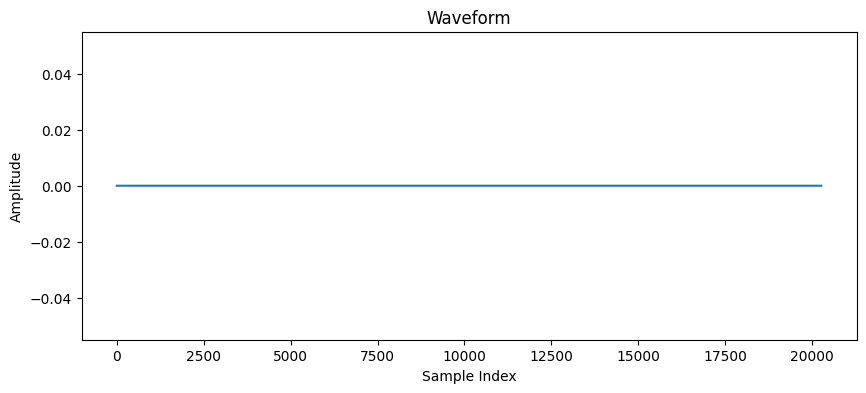

/usr/local/lib/python3.10/dist-packages/IPython/lib/display.py:174: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767


In [ ]:

# import torch
# from IPython.display import Audio
# import matplotlib.pyplot as plt

# # Assuming signal is your torch tensor
# # Extracting the first channel for visualization
# single_channel_signal = signal[0, 0, :]

# # Convert the torch tensor to a numpy array for plotting
# numpy_signal = single_channel_signal.numpy()

# # Plot the waveform
# plt.figure(figsize=(10, 4))
# plt.plot(numpy_signal)
# plt.title('Waveform')
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.show()

# # Display the audio for playback
# Audio(data=numpy_signal, rate=44100)  # Adjust the rate based on your actual sample rate


In [ ]:

# import torch
# from torchaudio.transforms import MelSpectrogram
# from IPython.display import Image, display
# import matplotlib.pyplot as plt

# # Assuming mel_spectrogram is your torch tensor
# # You can compute the Mel spectrogram from your signal using the provided configuration
# # mel_spectrogram = mel_spectrogram(signal)

# # Convert the torch tensor to a numpy array for plotting
# numpy_mel_spectrogram = mel_spectrogram.squeeze().numpy()
# mel_spectrogram.

# # Plot the Mel spectrogram
# plt.figure(figsize=(10, 4))
# plt.imshow(numpy_mel_spectrogram, cmap='viridis', origin='lower', aspect='auto')
# plt.title('Mel Spectrogram')
# plt.xlabel('Time')
# plt.ylabel('Mel Filter')
# plt.colorbar(format="%+2.0f dB")
# plt.show()

# # Save the plot as an image and display it using IPython.display
# plt.savefig("mel_spectrogram.png")
# display(Image(filename="mel_spectrogram.png"))


AttributeError: ignored

### NEW

In [ ]:
# # NEW SIGMOID

# # Define your fine-tuning model
# class FineTuningModel(nn.Module):
#     def __init__(self, wav2vec2_model, num_classes):
#         super(FineTuningModel, self).__init__()
#         self.wav2vec2 = wav2vec2_model

#         self.fc = nn.Sequential(
#             nn.Linear(1024,512),
#             nn.Linear(512,1),
#             nn.Sigmoid()
#         )

#         # self.wav2vec2.fc = nn.Sequential(
#         #     nn.Linear(1024,512),
#         #     nn.Softmax(dim = 1)
#         # )
#         # self.wav2vec2.to(device)

#     def forward(self, x):
#         x = self.wav2vec2(x)
#         x = self.fc(x)
#         return x


In [ ]:
# lst_result = []


# # Instantiate your fine-tuning model
# num_classes = 2  # Assuming binary classification, adjust as needed

# fine_tuning_model = FineTuningModel(pretrained_wav2vec2_model, num_classes)
# # fine_tuning_model = pretrained_wav2vec2_model #FineTuningModel(pretrained_wav2vec2_model, num_classes)

# # Move the model to the device (e.g., GPU)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# fine_tuning_model = fine_tuning_model.to(device)

# # Define loss function and optimizer
# criterion = nn.BCELoss() #CrossEntropyLoss()
# optimizer = optim.Adam(fine_tuning_model.parameters(), lr=0.005)

# # Instantiate DataLoaders for your dataset
# batch_size = 1  # Batch size is set to 1 since you have a batch size of 1 in your input tensor
# train_loader = DataLoader(train_sound_data, batch_size=batch_size, shuffle=True)

# valid_loader = DataLoader(valid_sound_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_sound_data, batch_size=batch_size, shuffle=False)

# # Training loop
# num_epochs = 1

# for epoch in range(num_epochs):
#     fine_tuning_model.train()
#     for inputs, labels in train_sound_data:
#         # inputs = inputs[0]
#         inputs = inputs.to(device)
#         labels = torch.from_numpy(np.array([labels]))
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         print(inputs)
#         outputs = fine_tuning_model(inputs)
#         # print('RAW OUTPUT', outputs)
#         if isinstance(outputs, tuple):
#             outputs = outputs[0][0]
#         # _, outputs = torch.max(outputs, 1)
#         ####### when BCE
#         labels = labels.to(torch.float)
#         outputs = outputs[0]
#         #########
#         # print('OUTPUT :', outputs)

#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation
#     fine_tuning_model.eval()
#     print("START VALIDATE")
#     with torch.no_grad():
#         total_correct = 0
#         total_samples = 0
#         for inputs, labels in valid_sound_data:
#             inputs = inputs.to(device)
#             labels = torch.from_numpy(np.array([labels]))
#             labels = labels.to(device)

#             outputs = fine_tuning_model(inputs)
#             print('TIS IS OUTPUT :',outputs)
#             print('OUTPUT TYPE :', type(outputs))
#             _, predictions = torch.max(outputs, 1)
#             total_correct += (predictions == labels).sum().item()
#             total_samples += labels.size(0)
#             # total_samples += 1 # len(labels.shape)

#             print(f'PRED :{predictions}\t LABEL :{labels}\t RESULT :{(predictions == labels)}')

#         accuracy = total_correct / total_samples
#         print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {accuracy:.4f}')

# # Testing
# fine_tuning_model.eval()
# with torch.no_grad():
#     total_correct = 0
#     total_samples = 0
#     for inputs, labels in test_sound_data:
#         inputs = inputs.to(device)
#         labels = torch.from_numpy(np.array([labels]))
#         labels = labels.to(device)

#         outputs = fine_tuning_model(inputs)
#         _, predictions = torch.max(outputs, 1)
#         total_correct += (predictions == labels).sum().item()
#         total_samples += labels.size(0)
#         print(f'PRED :{predictions}\t LABEL :{labels}\t RESULT :{(predictions == labels)}')
#     accuracy = total_correct / total_samples
#     print(f'Test Accuracy: {accuracy:.4f}')


